In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer,ToktokTokenizer
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.naive_bayes import MultinomialNB
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
data = pd.read_csv("data_input/Womens Clothing E-Commerce Reviews.csv")

In [3]:
data = data[['Review Text','Recommended IND']]

In [4]:
data.shape

(23486, 2)

In [5]:
data.rename(columns={'Review Text':'review_text','Recommended IND':'recommended'},inplace=True)

In [6]:
data.head(2)

,review_text,recommended
0,Absolutely wonderful - silky and sexy and comf...,1
1,Love this dress! it's sooo pretty. i happene...,1


In [7]:
data.isna().sum()

review_text    845
recommended      0
dtype: int64

In [8]:
data['review_text'] = data['review_text'].fillna(' ')

In [9]:
data.isna().sum()

review_text    0
recommended    0
dtype: int64

In [10]:
data.dtypes

review_text    object
recommended     int64
dtype: object

EDA

In [11]:
data.loc[data["recommended"] == 0, "recommended"] = "Not Recommended"
data.loc[data["recommended"] == 1, "recommended"] = "Recommended"

In [12]:
data.dtypes

review_text    object
recommended    object
dtype: object

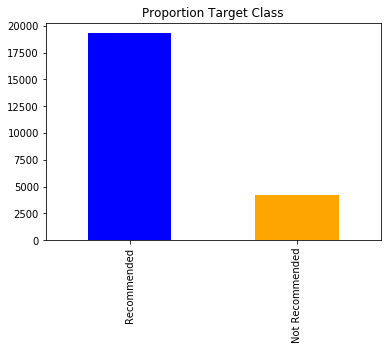

In [13]:
count_class=pd.value_counts(data["recommended"], sort= True)
count_class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Proportion Target Class')
plt.show()

In [14]:

count1 = Counter(" ".join(data[data['recommended']== 'Recommended']['review_text']).\
                 split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)


In [15]:
df1 = df1.rename(columns={0: "common_words", 1 : "count"})
df1.head(10)

,common_words,count
0,the,58954
1,i,40789
2,and,40389
3,a,35828
4,it,29788
5,is,25523
6,to,19767
7,this,16676
8,in,16506
9,but,12601


In [16]:
count2 = Counter(" ".join(data[data['recommended']== 'Not Recommended']['review_text']).\
                 split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)


In [17]:
df2 = df2.rename(columns={0: "common_words", 1 : "count"})
df2.head(10)

,common_words,count
0,the,15744
1,i,8841
2,and,8116
3,it,7514
4,a,6804
5,is,4799
6,to,4547
7,was,4137
8,this,4050
9,in,3705


Text Mining

In [18]:
tokenizer=ToktokTokenizer()
stopword_list=nltk.corpus.stopwords.words('english')

In [19]:
main_text = data['review_text']
target = data['recommended']

print(len(main_text))
print(len(target))

23486
23486


In [20]:

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text


main_text = main_text.apply(remove_between_square_brackets)
main_text = main_text.apply(remove_special_characters)

In [21]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

main_text = main_text.apply(lambda x: tokenizer.tokenize(x))

In [22]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopword_list]
    return words

main_text = main_text.apply(lambda x : remove_stopwords(x))

In [23]:
main_text

0        [Absolutely, wonderful, silky, sexy, comfortable]
1        [Love, dress, sooo, pretty, happened, find, st...
2        [I, high, hopes, dress, really, wanted, work, ...
3        [I, love, love, love, jumpsuit, fun, flirty, f...
4        [This, shirt, flattering, due, adjustable, fro...
                               ...                        
23481    [I, happy, snag, dress, great, price, easy, sl...
23482    [It, reminds, maternity, clothes, soft, stretc...
23483    [This, fit, well, top, see, never, would, work...
23484    [I, bought, dress, wedding, summer, cute, unfo...
23485    [This, dress, lovely, platinum, feminine, fits...
Name: review_text, Length: 23486, dtype: object

In [24]:
from nltk.stem import PorterStemmer

porter = PorterStemmer()
def stem_update(text_list):
    text_list_new = []
    for word in text_list:
        word = porter.stem(word)
        text_list_new.append(word) 
    return text_list_new
main_text = main_text.apply(stem_update)

In [25]:
main_text

0                  [absolut, wonder, silki, sexi, comfort]
1        [love, dress, sooo, pretti, happen, find, stor...
2        [I, high, hope, dress, realli, want, work, ini...
3        [I, love, love, love, jumpsuit, fun, flirti, f...
4        [thi, shirt, flatter, due, adjust, front, tie,...
                               ...                        
23481    [I, happi, snag, dress, great, price, easi, sl...
23482    [It, remind, matern, cloth, soft, stretchi, sh...
23483    [thi, fit, well, top, see, never, would, work,...
23484    [I, bought, dress, wed, summer, cute, unfortun...
23485    [thi, dress, love, platinum, feminin, fit, per...
Name: review_text, Length: 23486, dtype: object

In [26]:
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)
main_text = main_text.apply(drop_numbers)

In [27]:
main_text

0                        absolut wonder silki sexi comfort
1        love dress sooo pretti happen find store im gl...
2        I high hope dress realli want work initi order...
3        I love love love jumpsuit fun flirti fabul eve...
4        thi shirt flatter due adjust front tie perfect...
                               ...                        
23481    I happi snag dress great price easi slip flatt...
23482    It remind matern cloth soft stretchi shini mat...
23483    thi fit well top see never would work im glad ...
23484    I bought dress wed summer cute unfortun fit is...
23485    thi dress love platinum feminin fit perfectli ...
Name: review_text, Length: 23486, dtype: object

In [28]:
df = pd.concat([main_text,target],axis=1)

In [29]:
df.head(2)

,review_text,recommended
0,absolut wonder silki sexi comfort,Recommended
1,love dress sooo pretti happen find store im gl...,Recommended


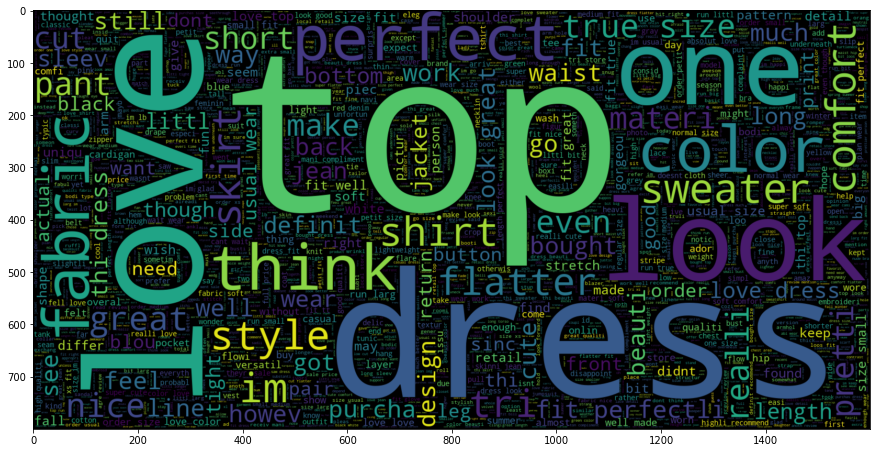

In [30]:


plt.figure(figsize = (15,15)) # Text that is recommended
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.recommended == 'Recommended'].review_text))
plt.imshow(wc , interpolation = 'bilinear')

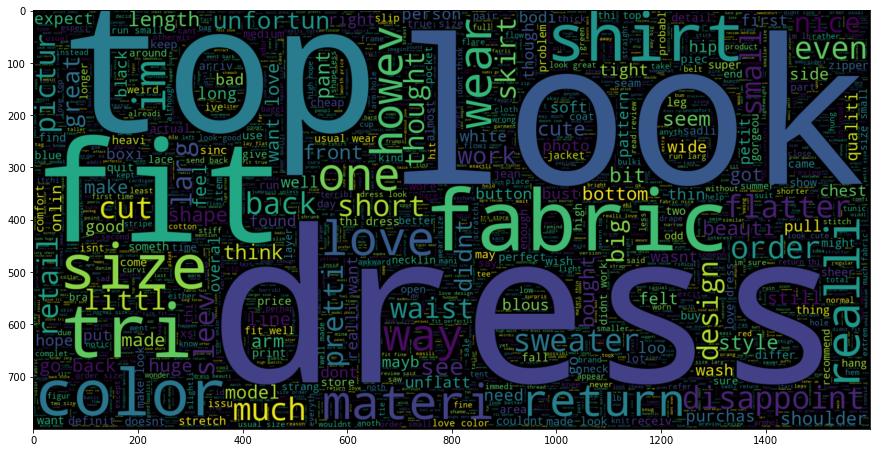

In [31]:
plt.figure(figsize = (15,15)) # Text that is not recommended
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.recommended == 'Not Recommended'].review_text))
plt.imshow(wc , interpolation = 'bilinear')

Modelling

In [32]:
cv=CountVectorizer()


train_data,test_data = train_test_split(df,train_size=0.8,random_state=0)

X_train = cv.fit_transform(train_data['review_text'])
y_train = train_data['recommended']
X_test = cv.transform(test_data['review_text'])
y_test = test_data['recommended']

In [33]:
nb = MultinomialNB()
nb.fit(X_train,y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [34]:
nb_predict=nb.predict(X_test)

In [39]:
nb_report = accuracy_score(y_test,nb_predict)
print('Accuracy:',nb_report)

Accuracy: 0.8903788846317582


In [36]:
nb_cm=confusion_matrix(y_test.values, nb.predict(X_test))

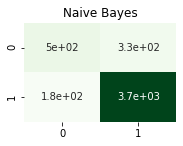

In [37]:
plt.subplot(2,2,2)
plt.title("Naive Bayes")
sns.heatmap(nb_cm, annot = True, cmap="Greens",cbar=False);

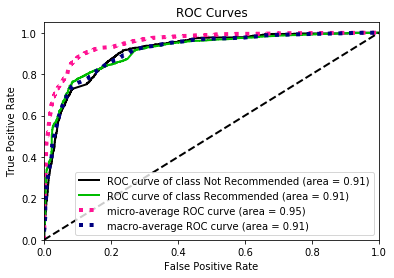

In [38]:
skplt.metrics.plot_roc(y_test, nb.predict_proba(X_test)) 